# Strength function from numerical basis sets

This notebook shows how the strength function can be approximated from a basis set made of the solutions of a numerical Hamiltonian. Given that only the bound and resonant states are found numerically, it is not possible to compute the contribution of the peak due to the bound and anti-bound states. Still, using the relations between the resonant and anti-resonant wavenumbers and wavefunctions, it is possible to build the strength function due to the resonant couples, as will be shown below.

Two main examples will be studied:

* the first one concerns the 1D Square-Well potential, where a comparison with the analytic result is possible. We'll see that the numerical and analytical results are in rather good agreement.

* we'll then be able to proceed to the case of the two Gaussian potentials, where we'll see the effect of the distance between the two wells on the strength function.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from siegpy import (Hamiltonian, ErfKGCoordMap, SWPotential,
                    SWPBasisSet, Gaussian, TwoGaussianPotential,
                    BasisSet)

## Square-Well potential case

Let us first start by finding the resonant states of a numerical Hamiltonian. The usual procedure is used:

In [2]:
# Define a grid
xmax = 7.5
xgrid = np.linspace(-xmax, xmax, 501)

In [3]:
# Define a potential, and discretize it over the grid
l = np.pi * np.sqrt(2)
V0 = 10
pot = SWPotential(l, V0, grid=xgrid)

In [4]:
# Initialize a coordinate mapping
x0 = 6.0
lbda = 1.5
cm = ErfKGCoordMap(0.6, x0, lbda)

In [5]:
# Initialize the Hamiltonian
ham = Hamiltonian(pot, cm)

In [6]:
# Find the eigenstates of the Hamiltonian
# with a virial selection to separate the
# Siegert states from the other eigenstates
basis = ham.solve(max_virial=10**(-6))

Once the basis set is initialized, one can define a test function and compute the strength function based on the resonant couples on a given wavenumber grid:

In [7]:
# Define the test function
xc = 0  # Center of the test functions
sigma = l/20.  # Width of the Gaussian
gauss1 = Gaussian(sigma, xc, grid=xgrid)

In [8]:
# Define the wavenumber grid for the strength function
step = 0.1  # Grid-step for plotting
k_max = 10  # Maximal wavenumber for plotting
kgrid = np.arange(step, k_max, step)

The same `plot_strength_function` method can be used, even though only the Mittag-Leffler Expansion of the strength function is available, compared to the analytical case. The contribution of a given number of resonant couples can still be highlighted:

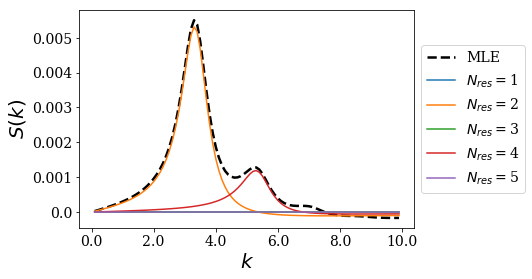

In [9]:
# Plot the MLE strength function
basis.plot_strength_function(gauss1, kgrid, nres=5)

The test function being centered in an even potential, the contribution of the odd resonant couples is obviously 0. The second and fourth resonant states are not odd, and this is why they have a non-zero contribution.

It is then possible to compare with the analytical result. 

Remember the strength function is given by:
$S(k) = - \frac{1}{\pi} \Im \left\langle g | G(k) | g \right\rangle$

where $G$ is the Green's function (or resolvent) of the Hamiltonian of the considered system and $g$ is the test function. The exact Green's function may be written as follows:

$G(k) = \sum_b \frac{\left| \varphi_b \right\rangle \left\langle \varphi_b \right|}{k^2/2 - {k_b}^2/2}
      + \sum_{p = \pm} \int_0^{+\infty} \text{d} k_1 \frac{\left| \varphi_p \right\rangle \left\langle \varphi_p \right|}{k^2/2 - {k_1}^2/2}$
      
and approximated by :
$G_{MLE}(k) = \sum_{S = a, b, c, d} \frac{\left| \varphi_S \right) \left( \varphi_S \right|}{k_S (k - k_S)}$.

This means that the numerical strength function depends on both the quality of the scalar product with the test function and on the position of the wavenumbers in the complex wavenumber plane. To make sure that the errors are not due to an insufficiently dense discretization grid, a basis set using the non-analytical scalar products for the analytical Siegert states is created (*i.e.*, `analytic = False`), along with the usual basis set using the analytical scalar product formulas with the test functions  (*i.e.*, `analytic = True`).

In [10]:
# Read the analytical basis set made of Siegert states
siegerts = SWPBasisSet.from_file("siegerts.dat", nres=20)
siegerts_not_an = SWPBasisSet.from_file("siegerts.dat", nres=20, analytic=False, grid=xgrid)

First, we can plot the exact contribution of the resonant couples only, using the analytical scalar product:

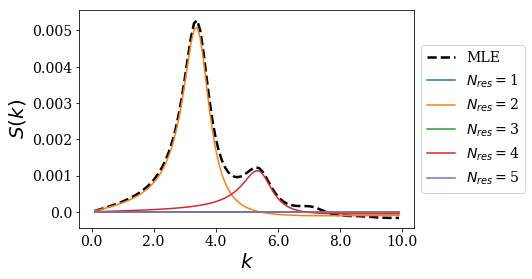

In [11]:
res_couples = siegerts.resonants + siegerts.antiresonants
res_couples.plot_strength_function(gauss1, kgrid, exact=False, nres=5)

The numerical results seem to reproduce the exact results. In order to have a clearer view on that point, let us plot both results in the same figure, along with the exact result using the bound and anti-bound states, and the exact result where `analytic = False`.

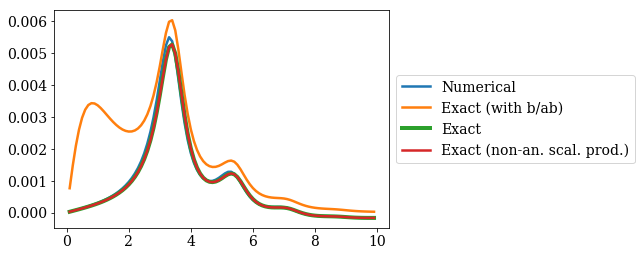

In [12]:
# Compute the various strength functions
sf = basis.MLE_strength_function(gauss1, kgrid)
exact_sf = siegerts.MLE_strength_function(gauss1, kgrid)
exact_res_sf = res_couples.MLE_strength_function(gauss1, kgrid)
res_couples_not_an = siegerts_not_an.resonants + siegerts_not_an.antiresonants
exact_res_sf_not_an = res_couples_not_an.MLE_strength_function(gauss1, kgrid)
# Plot them in the same figure
plt.plot(kgrid, sf, label="Numerical")
plt.plot(kgrid, exact_sf, label="Exact (with b/ab)")
plt.plot(kgrid, exact_res_sf, label="Exact", lw=4)
plt.plot(kgrid, exact_res_sf_not_an, label="Exact (non-an. scal. prod.)")
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

The peak corresponding to the bound and anti-bound states is missing, but it is still possible to get a very good agreement for all the other peaks. We also see that the discretization grid should be sufficient to give good enough non-analytic scalar products (both green and red curves are superimposed): the error is mainly due to the fact that the numerical Siegert states wavenumbers and wavefunctions do not exactly correspond to the analytical ones.

### Off-centered test function

If the same Gaussian is off-centered, the peaks associated to the odd resonant couples now show up. This means that there are more features in the spectrum:

In [13]:
# Define the off-centered test function
xc2 = l/8
gauss2 = Gaussian(sigma, xc2, grid=xgrid)

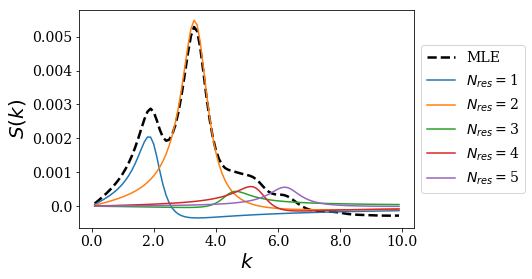

In [14]:
# Numerical MLE of the strength function
basis.plot_strength_function(gauss2, kgrid, nres=5)

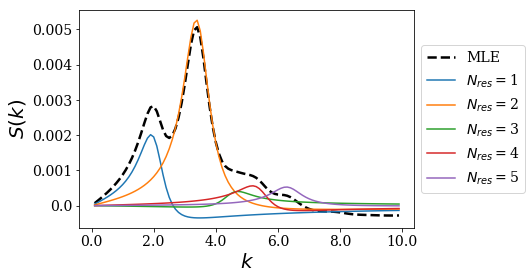

In [15]:
# Analytical strength function (except for bound and anti-bound peak)
res_couples = siegerts.resonants + siegerts.antiresonants
res_couples.plot_strength_function(gauss2, kgrid, exact=False, nres=5)

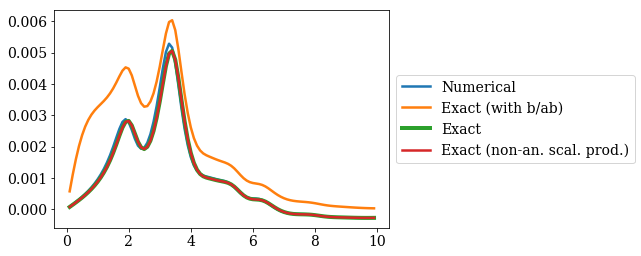

In [16]:
# Compute the various strength functions
sf = basis.MLE_strength_function(gauss2, kgrid)
exact_sf = siegerts.MLE_strength_function(gauss2, kgrid)
exact_res_sf = res_couples.MLE_strength_function(gauss2, kgrid)
res_couples_not_an = siegerts_not_an.resonants + siegerts_not_an.antiresonants
exact_res_sf_not_an = res_couples_not_an.MLE_strength_function(gauss2, kgrid)
# Plot them in the same figure
plt.plot(kgrid, sf, label="Numerical")
plt.plot(kgrid, exact_sf, label="Exact (with b/ab)")
plt.plot(kgrid, exact_res_sf, label="Exact", lw=4)
plt.plot(kgrid, exact_res_sf_not_an, label="Exact (non-an. scal. prod.)")
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

The conclusion found for the other test function still holds: the numerical strength function reproduces the exact one! It is possible to gain insight on the strength function by simply using a few numerical Siegert states.

## Two Gaussian functions potential

Given the previous section, it can be confidently said that the numerical Siegert states give high quality results for the strength function. New potentials can be safely studied: let us focus on the potential made of two Gaussian wells.

The influence of the distance between the two potential wells will be studied: the strength function for two case will be presented, while using the same test function. The first step therefore consists in obtain these strength functions: the same procedure as the one used above is used for both potentials.

### Gaussian wells close to each other 

Let us first compute the strength function for the case of two Gaussian wells close to each other:

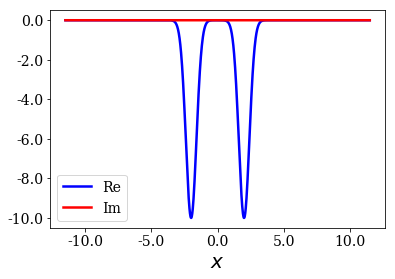

In [17]:
# Define a grid
xmax = 11.5
xgrid = np.linspace(-xmax, xmax,1201)
# Define a depth, sigma and center for the Gaussian potential
sigma = 0.4
xc = 2
V0 = 10
# Define a Potential with two Gaussian functions
sym_pot1 = TwoGaussianPotential(sigma, -xc, -V0, sigma, xc, -V0, grid=xgrid)
sym_pot1.plot()

In [18]:
# Create and solve the Hamiltonian
cm_g = ErfKGCoordMap(0.6, 10.0, 1.0)
ham1 = Hamiltonian(sym_pot1, cm_g)
basis1 = ham1.solve(max_virial=10**(-6))

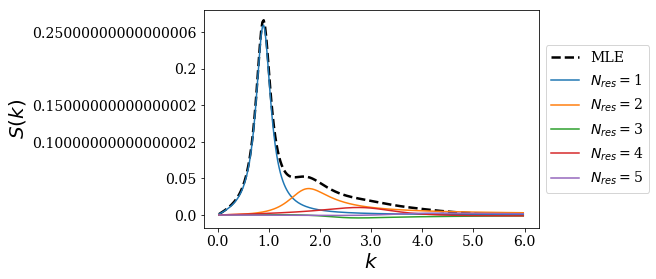

In [19]:
# Define the wavenumber grid
step1 = 0.025  # Grid-step for plotting
kmax1 = 6  # Maximal wavenumber for plotting
kgrid1 = np.arange(step1, kmax1, step1)
# Make sure the test function is discretized on the right grid
gauss2.grid = xgrid
# Plot the MLE of the strength function
basis1.plot_strength_function(gauss2, kgrid1, nres=5)

### Gaussian wells far from each other

The strength function for the two Gaussian wells further from each other is obtained in a similar fashion

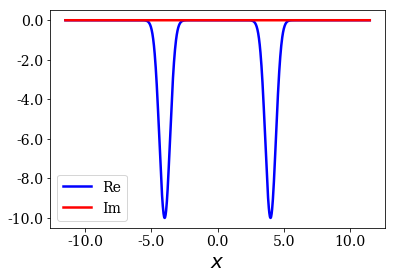

In [20]:
# Center of the new Gaussian wells
xc2 = 4
# Definition of the new potential
sym_pot2 = TwoGaussianPotential(sigma, -xc2, -V0, sigma, xc2, -V0, grid=xgrid)
sym_pot2.plot()

In [21]:
ham2 = Hamiltonian(sym_pot2, cm_g)
basis2 = ham2.solve(max_virial=10**(-8.7))

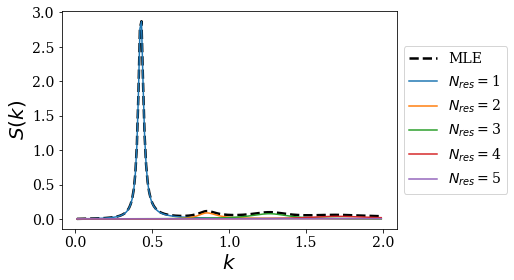

In [22]:
# Define the wavenumber grid
step2 = 0.01  # Grid-step for plotting
kmax2 = 2  # Maximal wavenumber for plotting
kgrid2 = np.arange(step2, kmax2, step2)
# Plot the MLE of the strength function
basis2.plot_strength_function(gauss2, kgrid2, nres=5)

### Discussion

Two very different strength functions have just been obtained, revealing the influence on the distance between the two Gaussian wells, which is actually related to the positions of the resonant states in the complex energy or wavenumber plane. Let us plot the energies of the resonant states of both basis sets to have that in mind:

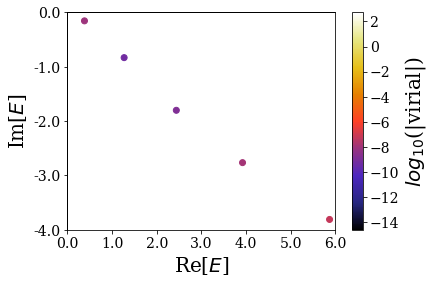

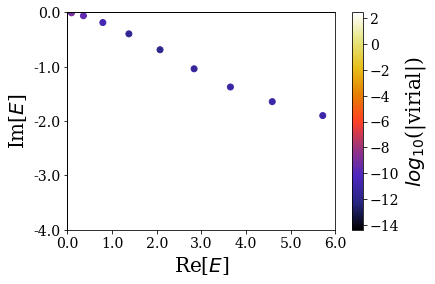

In [23]:
# Plot the energies of the resonant states of both basis sets
for basis in basis1, basis2:
    basis.plot_energies(xlim=(0, kmax1), ylim=(-4, 0), show_unknown=False)

As discussed in a previous notebook, increasing the distance between both Gaussian wells leads to denser (more Siegert states per energy range) and more stable Siegert states (their imaginary part is closer to 0). This fact is reflected in the strength function: the peak associated to a more stable state has a higher intensity and a smaller width: it actually tends to a Dirac delta for a bound state.

Having that in mind, it explains why the strength function obtained for the largest distance between the Gaussian wells has more intense peaks compared to the other one, with smaller width (the first peaks scarcely overlap). There are also more peaks per energy range.

## Conclusion

This notebook showed that the strength function using numerical Siegert states for any 1D potential could be readily obtained thanks to SiegPy. Even though it does not allow to reproduce the peak due to the bound and anti-bound states contributions, all other peaks can be reproduced, and they are in very good agreement to the exact strength function, that is known for the 1D SWP, showing that the results for other potentials can be trusted.